In [1]:
#@title Your Info { display-mode: "form" }

Name = 'Rathul Anand' #@param {type:"string"}

# DataRes Research Coding Assessment

## Due by 11:59pm, January 12

Thanks for taking the time to apply to the research team at DataRes! This assessment consists of handful of machine learning exercises that use PyTorch. If you aren't familiar with this library, there's lots of helpful documentation [here](https://pytorch.org/docs/stable/index.html). Lots of code has already been written for you, just make sure to complete sections marked "TODO:" or "Your Implementations". There are a number of challenging problems to work on, so if you have any questions, please feel free to reach out to [Lukas](mailto:lukasbroc@gmail.com) or [Sammy](mailto:sammy7shang@gmail.com) at any time! Lastly, please feel free to submit the assessment even if you can't finish it all, we will take the time to look at every application we recieve.

Make sure to submit this completed assessment by 11:59pm, October 10. Submissions will be turned in by emailing this notebook as an .ipynb and the .json with your model's results (more on this below) to both of us.

Good luck!

### Overview

In this assessment, you will be working with the [MiniPlaces dataset](https://github.com/CSAILVision/miniplaces), a dataset of scene images (10+ million images) with a wide variety of real-world environments (400+ unique scene categories). The MiniPlaces dataset is a subset of the [Places2 dataset](http://places2.csail.mit.edu/) and contains 100,000 images for training, 10,000 images for validation, and 10,000 images for testing, each of which has been annotated with one of 100 different scene categories. These images are divided into three folders: train, val, and test.

Question 1 will use only some categories of this dataset. We've called this new dataset TinyPlaces. Questions 2-4 will use MiniPlaces (all subcategories).

You will be completing machine learning exercises in which you will train models using this dataset. These exercises touch on the following topics:


*   Linear, Logistic, and Softmax Regression
*   Multi-Layer Perceptrons
*   Convolutional Neural Networks (CNNs)

Don't worry about having to deal with preprocessing the data... we've already written code to do that for you! Just run the cell below.



In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt

In [3]:
import os
path = './'
os.makedirs(os.path.join(path, 'DataRes_Research_Assessment', 'data'), exist_ok=True)
root_dir = os.path.join(path, 'DataRes_Research_Assessment')

!wget https://web.cs.ucla.edu/~smo3/data.tar.gz

import tarfile
from tqdm import tqdm

tar = tarfile.open("data.tar.gz", "r:gz")
total_size = sum(f.size for f in tar.getmembers())
with tqdm(total=total_size, unit="B", unit_scale=True, desc="Extracting tar.gz file") as pbar:
    for member in tar.getmembers():
        tar.extract(member, os.path.join(root_dir, 'data'))
        pbar.update(member.size)
tar.close()

--2024-01-13 07:13:12--  https://web.cs.ucla.edu/~smo3/data.tar.gz
Resolving web.cs.ucla.edu (web.cs.ucla.edu)... 131.179.128.29
Connecting to web.cs.ucla.edu (web.cs.ucla.edu)|131.179.128.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460347416 (439M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 439.02M  44.3MB/s    in 9.9s    

2024-01-13 07:13:22 (44.3 MB/s) - ‘data.tar.gz’ saved [460347416/460347416]



Extracting tar.gz file: 100%|██████████| 566M/566M [00:20<00:00, 27.9MB/s]


In [4]:
import urllib.request

import os
import pickle

import numpy as np

def load_subcategories(txt_path):
    subcategories = {}
    file = open(txt_path, 'r')
    lines = file.readlines()
    for i, l in enumerate(lines):
        info = l.split()
        info[0] = info[0][3:]
        subcategories.update({info[0]: {'ori_class_id': int(info[1]), 'class_id': i}})

    return subcategories


from tqdm import trange
import cv2
import random

def select_samples(subcategories, root_dir, split, n_images_per_subcategory):
    samples = []
    if split == "train":
        train_dir = os.path.join(root_dir, "data", "images", "train")
        for i in subcategories:
            child_dir = os.path.join(train_dir, i[0], i)
            pics = random.sample(os.listdir(child_dir), n_images_per_subcategory)
            for j in pics:
                samples.append((cv2.resize(cv2.imread(os.path.join(child_dir, j)), (32,32)).flatten().tolist(), subcategories[i]["class_id"]))
    elif split == "val":
        val_dir = os.path.join(root_dir, "data", "images")
        file = open(os.path.join(root_dir, "data", "val.txt"), 'r')
        lines = file.readlines()
        val_data = []
        for i in lines:
            val_data.append(i.split())
        random.shuffle(val_data)
        for i in subcategories:
            old_id = subcategories[i]["ori_class_id"]
            count = 0
            for j in val_data:
                if int(j[1]) == old_id:
                    samples.append((cv2.resize(cv2.imread(os.path.join(val_dir, j[0])), (32,32)).flatten().tolist(), subcategories[i]["class_id"]))
                    count += 1
                if count >= n_images_per_subcategory:
                    break
    return samples

def create_tinyplaces(samples, binary=True):
    data, labels = [], []
    for i in samples:
        data.append(i[0])
        if binary:
            if i[1] >= 10:
                labels.append(1)
            else:
                labels.append(0)
        else:
            labels.append(i[1])
    data = np.array(data)
    labels = np.array(labels)
    dataset = {"data": data, "label": labels}

    return dataset


# Set the root directory of the dataset
root_dir = './DataRes_Research_Assessment'

# Load the target subcategories and their class IDs
subcategories = load_subcategories(os.path.join(root_dir, 'data', 'categories_tinyplaces.txt'))

# Select the samples from the train split of the TinyPlaces dataset
train_samples = select_samples(subcategories, root_dir, 'train', 500)

# Create the TinyPlaces datasets for binary and multiclass classification
tinyplaces_binary_train = create_tinyplaces(train_samples, binary=True)
tinyplaces_multi_train = create_tinyplaces(train_samples, binary=False)

# Select the samples from the val split of the MiniPlaces dataset
val_samples = select_samples(subcategories, root_dir, 'val', 50)

# Create the TinyPlaces datasets for binary and multiclass classification
tinyplaces_binary_val = create_tinyplaces(val_samples, binary=True)
tinyplaces_multi_val = create_tinyplaces(val_samples, binary=False)

# Save the TinyPlaces datasets to the data directory
data_dir = os.path.join(root_dir, 'data')


with open(os.path.join(data_dir, 'tinyplaces_binary_train.pkl'), 'wb') as f:
    pickle.dump(tinyplaces_binary_train, f)

with open(os.path.join(data_dir, 'tinyplaces_multi_train.pkl'), 'wb') as f:
    pickle.dump(tinyplaces_multi_train, f)

with open(os.path.join(data_dir, 'tinyplaces_binary_val.pkl'), 'wb') as f:
    pickle.dump(tinyplaces_binary_val, f)

with open(os.path.join(data_dir, 'tinyplaces_multi_val.pkl'), 'wb') as f:
    pickle.dump(tinyplaces_multi_val, f)


class TinyPlacesDataset(object):
    def __init__(self, data_dict):
        self.dataset = data_dict
        self.num_samples = len(data_dict['data'])

    def subsample(self, ratio=0.1, seed=None):
        if seed is not None:
            np.random.seed(seed)

        nums = random.sample(range(self.num_samples), int(ratio * self.num_samples))
        sub_dataset = {'data': self.dataset['data'][nums], 'label': self.dataset['label'][nums]}
        subsampled_dataset = TinyPlacesDataset(sub_dataset)

        return subsampled_dataset

## GPU

You will train your models using the GPU. Go to:
Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU

In [5]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device == torch.device('cuda'):
    print(f'Using device: {device}. Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Using device: cuda. Good to go!


In [6]:
# This line of code gives you info about GPU
! nvidia-smi

Sat Jan 13 07:17:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              43W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [7]:
with open(os.path.join(root_dir, 'data', 'tinyplaces_binary_train.pkl'), 'rb') as f:
    binary_train = TinyPlacesDataset(pickle.load(f))
with open(os.path.join(root_dir, 'data', 'tinyplaces_binary_val.pkl'), 'rb') as f:
    binary_val = TinyPlacesDataset(pickle.load(f))
with open(os.path.join(root_dir, 'data', 'tinyplaces_multi_train.pkl'), 'rb') as f:
    multi_train = TinyPlacesDataset(pickle.load(f))
with open(os.path.join(root_dir, 'data', 'tinyplaces_multi_val.pkl'), 'rb') as f:
    multi_val = TinyPlacesDataset(pickle.load(f))

# Convert everything from numpy arrays to tensors and move them to the GPU using .cuda()
for dataset in [binary_train, binary_val, multi_train, multi_val]:
    for k in ['data', 'label']:
        dataset.dataset[k] = torch.tensor(dataset.dataset[k]).float().cuda()

In [8]:
from tqdm import tqdm

## Q1 Regressions

### Linear Regression

Below, you will implement linear regression. You'll need to use PyTorch to initialize the parameters and implement the linear function and mean squared error.

If the prediction score > 0.5, we consider the image to be of outdoor category. Otherwise, we consider it to be indoor category.

In [9]:
class LinearRegression(object):
    def __init__(self, input_size, output_size):
        """
          Initialize the weights and biases using zeros distribution

          Parameters:
              input_size (int): The input size (dimension of feature vectors)
              output_size (int): The output size (dimension of output logits)

          Returns:
              None.
        """
        # Initialize the weights and biases using zeros
        # Make sure your tensors keep track of their gradient
        # Move the parameters to GPU (cuda)
        ################# Your Implementations #################################

        self.W = Variable(torch.zeros(output_size, input_size, device=device).double(), requires_grad=True)
        self.b = Variable(torch.zeros(output_size, device=device).double(), requires_grad=True)


        ################# End of your Implementations ##########################

    def linear(self, x):
        ################# Your Implementations #################################

        x.to(device)
        output = torch.matmul(self.W, torch.transpose(x, 0, 1))
        output += self.b.unsqueeze(1)


        ################# End of your Implementations ##########################
        return output

    def forward(self, x):
        # To make the output shape compact.
        return self.linear(x).squeeze()

    def get_loss(self, pred_logits, targets):
        # Calculate the mean squared error between the predicted labels and the ground-truth labels
        loss = None
        ################# Your Implementations #################################

        loss = torch.sum(torch.square(pred_logits - targets))/(torch.numel(targets))

        ################# End of your Implementations ##########################
        return loss

    def fit(self, x, y, x_val, y_val, lr, epochs=500000, print_freq=1000):
        # Fit the linear regression model to the training data using gradient descent
        # x is the input data, y is the ground-truth labels
        # lr is the learning rate, epochs is the number of epochs

        # To store validation accuracy
        val_accs = []
        # Create a progress bar using tqdm
        pbar = tqdm(range(epochs))
        for epoch in pbar:
            # Calculate the loss
            y_pred_logits = self.forward(x)
            loss = self.get_loss(y_pred_logits, y)
            # Backpropagate the loss to compute the gradients
            loss.backward()
            # Update the weights and biases using gradient descent
            with torch.no_grad():
                self.W -= lr * self.W.grad
                self.b -= lr * self.b.grad
                # Reset the gradients
                self.W.grad.zero_()
                self.b.grad.zero_()

            if epoch % print_freq == 0:
                # Calculate the validation accuracy
                val_acc = self.evaluate(x_val, y_val)
                val_accs.append(val_acc)
                # Update the progress bar with the validation accuracy and training loss
                pbar.set_description(f'val_acc: {val_acc:.3f}')
        return val_accs

    def evaluate(self, x, y):
        # Evaluate the performance of the linear regression model on the dataset
        # x is the input data, y is the ground-truth labels
        # Calculate the predicted labels
        y_pred = self.forward(x) > 0.5
        return (y_pred == y).float().mean().item()

In [10]:
def normalize(x):
    # We can simply divide x by 255 since its range is (0,255)
    return x / 255.

In [11]:
# Here "ori" indicates "original"
X_train_ori, y_train = binary_train.dataset['data'], binary_train.dataset['label']
X_val_ori, y_val = binary_val.dataset['data'], binary_val.dataset['label']

# Normalization
X_train = normalize(X_train_ori)
X_val = normalize(X_val_ori)

Use the next 3 cells to debug. The next cell should give an accuracy of 0.5 since we're using zeros-initialization.

In [12]:
linear_model = LinearRegression(3072, 1)
train_acc = linear_model.evaluate(X_train.double(), y_train)
val_acc = linear_model.evaluate(X_val.double(), y_val)
print('train accuracy:', train_acc)
print('val accuracy:', val_acc)

train accuracy: 0.5
val accuracy: 0.5


In [13]:
# Try to debug using this cell
linear_model = LinearRegression(3072, 1)
# We refer the raw outputs from a model to as "logits",
# i.e., we haven't transformed the results to binary labels.
y_pred_logits = linear_model.forward(X_train.double())
loss = linear_model.get_loss(y_pred_logits, y_train)
print("loss:", loss.item())

loss: 0.5


In [14]:
# compute gradients
loss.backward()

# check the gradients
print(linear_model.W.grad)
print(linear_model.b.grad)

tensor([[-0.5270, -0.5004, -0.4523,  ..., -0.3006, -0.3535, -0.3627]],
       device='cuda:0', dtype=torch.float64)
tensor([-1.0000], device='cuda:0', dtype=torch.float64)


Great, you've fully implemented the linear regression model! Let's train it.

In [15]:
linear_model = LinearRegression(3072, 1)
# You can reduce the number of training epochs to debug
lin_val_accs = linear_model.fit(X_train.double().cuda(), y_train, X_val.double().cuda(), y_val, 1e-4, 500000, 1000)

val_acc: 0.771: 100%|██████████| 500000/500000 [04:54<00:00, 1699.29it/s]


### Logistic Regression

Logistic regression is very similar to linear regression, but the sigmoid function is added to the forward pass and cross-entropy is used for loss. Here's the formulas:

Sigmoid:

$$\frac{1}{1+e^{-x}}$$

Cross-Entropy Loss:

$$\mathrm{CE_Loss}(p, y) = -{(y\log(p) + (1-y)\log(1-p))}$$

Implement them below!

In [16]:
def sigmoid(x):
    ################# Your Implementations #################################

    output = 1/(1+torch.exp(-x))

    ################# End of your Implementations ##########################
    return output


def cross_entropy_loss(p, y):
    ################# Your Implementations #################################

    epsilon = 1e-10
    p = torch.clamp(p, epsilon, 1 - epsilon)

    # Based on probability distribution p, logits y
    output = -torch.div(torch.sum(torch.mul(y, torch.log(p))+torch.mul((1-y), torch.log(1-p))),p.numel())


    ################# End of your Implementations ##########################
    return output

Use these implementations below to implement the Logistic Regression model.

In [17]:
class LogisticRegression(LinearRegression):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__(input_size, output_size)

    def forward(self, x):
        # Apply the sigmoid function to the linear output
        ################# Your Implementations #################################

        output = self.linear(x)
        output = sigmoid(output)


        ################# End of your Implementations ##########################
        return output

    def get_loss(self, pred_logits, targets):
        # Calculate the cross-entropy loss
        ################# Your Implementations #################################

        loss = cross_entropy_loss(pred_logits, targets)

        ################# End of your Implementations ##########################
        return loss

Train!

In [18]:
logistic_model = LogisticRegression(3072, 1)
logi_val_accs = logistic_model.fit(X_train.double(), y_train, X_val.double(), y_val, 1e-4, 500000, 1000)

val_acc: 0.802: 100%|██████████| 500000/500000 [08:17<00:00, 1004.26it/s]


Plot the validation accuracies of both models. Logistic Regression should be more accurate.

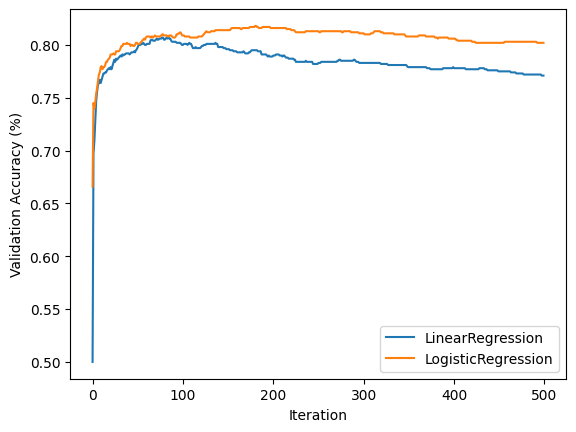

In [19]:
import matplotlib.pyplot as plt

plt.plot(lin_val_accs, label='LinearRegression')
plt.plot(logi_val_accs, label='LogisticRegression')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy (%)')
plt.show()

### Softmax Regression

Softmax regression is similar to logistic regression except it uses the softmax function instead of sigmoid and uses negative log likelihood for the loss. Here's the formulas:

Softmax:

$$\frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$$

where z is the output of the linear model, and K is the number of classes.

Negative Log Likelihood:

$$-{\log(p(y))}$$

where p(y) is the predicted probability of the data point belonging to the true class y.

Implement them below!

In [20]:
def softmax(x):
    # Implement the softmax function
    # x is the input data with shape (batch_size, input_size)
    # Return the softmax output with shape (batch_size, output_size)
    ################# Your Implementations #################################

    ex = torch.exp(x)
    output = torch.div(ex, torch.sum(ex, axis=1, keepdim=True))


    ################# End of your Implementations ##########################
    return output

def nll_loss(pred_probs, targets):
    # Calculate the negative log likelihood loss
    # pred_probs is the predicted probability distribution with shape (batch_size, output_size)
    # targets is the ground-truth labels with shape (batch_size,)
    # Return the negative log likelihood loss with shape (batch_size,)

    # Hine: Convert the ground-truth labels to one-hot encoding using torch.eye()
    ################# Your Implementations #################################


    pred_probs = pred_probs.t()
    one_hot_targets = torch.eye(pred_probs.shape[1], device=device)[targets.to(torch.int64)]
    loss = -torch.log(torch.sum(torch.mul(pred_probs, one_hot_targets), dim=1))
    loss = loss.mean()
    return loss


    ################# End of your Implementations ##########################
    return loss

Use these implementations below to implement the Softmax Regression model.

In [21]:
class SoftmaxRegression(LinearRegression):
    def __init__(self, input_size, output_size):
        super(SoftmaxRegression, self).__init__(input_size, output_size)

    def forward(self, x):
        # Apply the softmax function to the linear output
        ################# Your Implementations #################################


        output = self.linear(x)
        output = softmax(output)


        ################# End of your Implementations ##########################
        return output

    def get_loss(self, pred_logits, targets):
        # Calculate the cross-entropy loss
        ################# Your Implementations #################################

        loss = nll_loss(pred_logits, targets)

        ################# End of your Implementations ##########################
        return loss

    def evaluate(self, x, y):
        # Evaluate the performance of the linear regression model on the dataset
        # x is the input data, y is the ground-truth labels
        # Calculate the predicted labels
        y_pred = self.forward(x)
        y_pred = y_pred.argmax(dim=0)
        return (y_pred == y).float().mean().item()


In [22]:
# Prepare multi-class dataset
# Here "ori" indicates "original"
X_train_ori_multi, y_train_multi = multi_train.dataset['data'], multi_train.dataset['label']
X_val_ori_multi, y_val_multi = multi_val.dataset['data'], multi_val.dataset['label']

# Normalization
X_train_multi = normalize(X_train_ori_multi)
X_val_multi = normalize(X_val_ori_multi)

Train! Don't worry if your accuracy is low, that's expected.

In [23]:
sfm_model = SoftmaxRegression(3072, 20)
sfm_val_accs = sfm_model.fit(X_train_multi.double(), y_train_multi, X_val_multi.double(), y_val_multi, 1e-4, 100000, 1000)

val_acc: 0.218: 100%|██████████| 100000/100000 [01:28<00:00, 1129.60it/s]


### Comparison

In your own words, explain the differences between Linear Regression, Logistic Regression and Softmax Regression:

The fundamental difference between the three types of regression techniques are the shape of the function we are using to model the data. In linear regression, we map the data to a linear function, which is often used for tracking continuous data. This is often used for regression tasks, rather than classification tasks. For classification, we often use logistic regression instead, which maps the data to a logistic function with an output range of 0 to 1, representing probabilities. We can then set a threshold between 0 and 1 above which and below which the data will be classified to two binary classes. Softmax regression is a generalization atop logistic regression where we use multinomal logistic functions to classify the variables to more than 2 classes.

## Q2: Multi-Layer Perceptron (MLP)

Now, we'll be using MiniPlaces, so there will be 100 different labels (instead of 20).

You will use PyTorch to implement linear layers and ReLu to create a multi-layer perceptron.

In [24]:
from torch.utils.data import Dataset
from PIL import Image

class MiniPlaces(Dataset):
    def __init__(self, root_dir, split, transform=None, label_dict=None):
        assert split in ['train', 'val', 'test']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.filenames = []
        self.labels = []
        self.label_dict = label_dict if label_dict is not None else {}
        if split == "train" or split == "val":
            with open(os.path.join(root_dir, ("train" if self.split == "train" else "val") + ".txt")) as f:
                for line in f:33
                    line = line.rstrip().split()
                    n = int(line[0][-12:-4])
                    if n <= 900:
                        self.filenames.append(os.path.join(line[0]))
                        self.labels.append(int(line[1]))
        if label_dict is None and split == "train":
            with open(os.path.join(root_dir, "train.txt")) as f:
                num = -1
                for line in f:
                    line = line.rstrip().split()
                    if int(line[1]) > num:
                        num += 1
                        self.label_dict.update({int(line[1]): line[0][8:line[0].find("/", 8)]})
        if split == "test":
            self.labels = os.listdir(os.path.join(root_dir, "images", "test"))
            self.filenames = ["test/" + i for i in self.labels]

    def __len__(self):
        dataset_len = len(self.labels)
        return dataset_len

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root_dir, "images", self.filenames[idx]))
        if not self.transform is None:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

from torchvision import transforms

data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

data_root = os.path.join(root_dir, 'data')
miniplaces_train = MiniPlaces(data_root, split='train', transform=data_transform)
miniplaces_val = MiniPlaces(
    data_root, split='val',
    transform=data_transform,
    label_dict=miniplaces_train.label_dict)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [26]:
class FastMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        """
        Initialize an MLP classifier.
        Input and output sizes of each layer:
          1) fc1: input_size, hidden_size
          2) fc2: hidden_size, hidden_size
          3) fc3: hidden_size, num_classes

        Args:
            input_size (int): Size of the input layer.
            hidden_size (int): Size of the hidden layer.
            num_classes (int): Number of classes in the output layer.
        """
        super().__init__()
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None
        ################# Your Implementations #################################
        # TODO: Define the layers of the MLP
        # Hint: The imported modules should give you a clue on which PyTorch functions to use

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)


        ################# End of your Implementations ##########################

    def forward(self, x):
        """
        Forward pass of the MLP classifier.
        Using ReLU as the activation function after each layer, except for the output layer.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the MLP classifier

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)


        ################# End of your Implementations ##########################
        return x



Then, define the training and evaluation functions to train and test the MLP classifier (You don't need to modify this part):

In [42]:
def train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs):
    # Place model on device
    model = model.to(device)
    best_acc = 0
    flag = False
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Zero out gradients
                optimizer.zero_grad()
                # Compute the logits and loss
                logits = model(inputs)
                loss = criterion(logits, labels)
                # Backpropagate the loss
                loss.backward()
                # Update the weights
                optimizer.step()
                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

        # Evaluate the model on the validation set
        avg_loss, accuracy = evaluate(model, val_loader, criterion, device)
        if best_acc > accuracy:
            if flag:
                print(f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')
                break
            else:
                flag = True
        else:
            best_acc = accuracy
            flag = False
        print(f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')

def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the classifier on the test set.

    Args:
        model: classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy

def predict(model, test_dataloader):
    """
    Evaluate the classifier on the test set.

    Args:
        model: classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    out = []
    for i in tqdm(test_dataloader, total=len(test_dataloader)):
        pic = i[0]
        lab = torch.argmax(model.to('cpu')(pic))
        out.append(lab.item())

    return out

data_transform_flatten = transforms.Compose([data_transform, torch.flatten])

In [28]:
model = FastMLP(
    input_size=3 * 64 * 64,
    hidden_size=1024,
    num_classes=len(miniplaces_train.label_dict))
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9)
criterion = nn.CrossEntropyLoss()

data_root = os.path.join(root_dir, 'data')
train_dataset = MiniPlaces(
    root_dir=data_root, split='train',
    transform=data_transform_flatten)
val_dataset = MiniPlaces(
    root_dir=data_root, split='val',
    transform=data_transform_flatten,
    label_dict=train_dataset.label_dict)

### !!! DON'T CHANGE NUM_WORKERS FROM 0 !!!
### Using the loader will crash the notebook

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, num_workers=0, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, num_workers=0, shuffle=False)

Train!

In [29]:
train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1407/1407 [01:19<00:00, 17.61it/s, loss=3.13]


Validation set: Average loss = 3.8785, Accuracy = 0.1244


Epoch 2/2: 100%|██████████| 1407/1407 [01:20<00:00, 17.44it/s, loss=3.92]


Validation set: Average loss = 3.8321, Accuracy = 0.1344


Don't worry if your accuracy is low, that's to be expected.

## Q3: Convolutional Neural Network (CNN)

This question is similar to the last, but you'll be implementing a convolutional neural network instead. You'll need to use convolutional layers, a max pooling layer, and dropout layers.

In [30]:
class FastConv(nn.Module):
    def __init__(
        self,
        input_channels, conv_hidden_channels, conv_out_channels,
        input_size=(64,64),
        dropout_rate1=0.25, dropout_rate2=0.5,
        fc_out_channels=128, num_classes=100,
        kernel_size=3, stride=1, padding=1):
        """
        Args:
          input_channels (int): Number of channels in the input image.
          conv_hidden_channels (int): Number of channels in the first convolutional layer.
          conv_out_channels (int): Number of channels in the second convolutional layer.
          input_size (tuple, optional): Height and width of the input image. (default: (64,64))
          dropout_rate1, dropout_rate2 (float, optional): Dropout rate for
              the first/second dropout layer. (default: 0.25, 0.5)
          fc_out_channels (int, optional): Number of neurons in the first fully
              connected layer. (default: 128)
          num_classes (int, optional): Number of classes in the final output layer. (default: 100)
          kernel_size, stride, padding (int, optional): Parameters of convolutional layers.

        Initialize a convolutional neural network.
        You can use Pytorch's built-in nn.Conv2d function.
        Input and output shapes of each layer:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        3) max_pooling: (batch_size, conv_out_channels, H, W)
        4) fc1: (batch_size, flatten_size) -> (batch_size, fc_out_channels)
        5) fc2: (batch_size, fc_out_channels) -> (batch_size, num_classes)
        """

        super().__init__()

        # We've given you 'flatten_size', since we aren't expecting you to have this formula memorized :)
        flatten_size = conv_out_channels * int(((input_size[0] + (2 * padding) - kernel_size) / kernel_size) + 1) * int(((input_size[1] + (2 * padding) - kernel_size) / kernel_size) + 1)

        self.conv1 = None
        self.conv2 = None
        self.max_pooling = None
        self.dropout1 = None
        self.dropout2 = None
        self.fc1 = None
        self.fc2 = None

        ################# Your Implementations #################################
        # TODO: Define the layers of the convolutional neural network
        # replace "None"s with your implementations.
        # All you need to do is to pass the input arguments to different constructors

        # We need to change flatten_size to take into account the stride
        flatten_size = conv_out_channels * int(((input_size[0] + (2 * padding) - kernel_size) / stride) + 1) * int(((input_size[1] + (2 * padding) - kernel_size) / stride) + 1) // 4
        self.conv1 = nn.Conv2d(input_channels, conv_hidden_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(conv_hidden_channels, conv_out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.max_pooling = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout(p=dropout_rate1)
        self.dropout2 = nn.Dropout(p=dropout_rate2)
        self.fc1 = nn.Linear(flatten_size, fc_out_channels)
        self.fc2 = nn.Linear(fc_out_channels, num_classes)

        ################# End of your Implementations ##########################

    def forward(self, x, return_intermediate=False):
        """
        Forward pass of the convolutional neural network.
        The input tensor 'x' should pass through the following layers:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) Apply relu.
        3) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        4) max_pooling: Perform max pooling on the output from conv2
        5) dropout1: Perform dropout on the output from max_pooling
        6) Flatten the output from dropout1
        7) fc1: Pass through a fully connected layer
        8) dropout2: Perform dropout on the output from fc1
        9) Apply relu.
        10) fc2: Pass the output from the actiction layer to through a fully connected
                layer to produce the final output
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the convolutional neural network

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.max_pooling(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.fc2(x)

        ################# End of your Implementations ##########################
        return x


In [31]:
conv_train_dataset = MiniPlaces(
    root_dir=data_root, split='train',
    transform=data_transform)
conv_val_dataset = MiniPlaces(
    root_dir=data_root, split='val',
    transform=data_transform)
conv_train_loader = torch.utils.data.DataLoader(
    conv_train_dataset, batch_size=64, num_workers=0, shuffle=True)
conv_val_loader = torch.utils.data.DataLoader(
    conv_val_dataset, batch_size=64, num_workers=0, shuffle=False)

model = FastConv(
    input_channels=3, conv_hidden_channels=64, conv_out_channels=128,
    input_size=(64,64),
    dropout_rate1=0.25, dropout_rate2=0.5,
    fc_out_channels=128,
    kernel_size=3, stride=1, padding=1,
    num_classes=len(miniplaces_train.label_dict))
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

Train!

In [32]:
train(model, conv_train_loader, conv_val_loader, optimizer, criterion, device, num_epochs=2)

Epoch 1/2: 100%|██████████| 1407/1407 [01:27<00:00, 16.13it/s, loss=3.7]


Validation set: Average loss = 3.5974, Accuracy = 0.1578


Epoch 2/2: 100%|██████████| 1407/1407 [01:26<00:00, 16.23it/s, loss=3.37]


Validation set: Average loss = 3.5093, Accuracy = 0.1778


I can get ~20% accuracy after two epochs. How about you?

## Q4: Your own model

You will construct your own model using built-in convolutional layers. You can base your model on the provided `FastConv` class, or choose to modify the number of convolutional layers, feature size, learning rate, optimizer, and other parameters to suit your needs. You can also use any data transformations you'd like. You can even base your model off of an already existing architecture. The only restriction is that you can't blindly import an entire model at once; you should be creating every layer using PyTorch. Create your model and train using cells below.

In [ ]:
### Use these cells to design and train your model

In [ ]:
### Previous questions will be super useful

In [33]:
# Define pre-train transformations
data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

In [34]:
# Data augmentation to prevent overfitting
data_augmentation = nn.Sequential(
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop((64, 64), padding=(4, 4))
)

data_augmentation = torch.jit.script(data_augmentation)

In [35]:
# Create datasets and dataloaders

batch_size = 64

train_dataset = MiniPlaces(
    root_dir=data_root, split='train',
    transform=transforms.Compose([
        data_transform,
        data_augmentation]))
val_dataset = MiniPlaces(
    root_dir=data_root, split='val',
    transform=data_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

In [36]:
class CNN(nn.Module):
    def __init__(
            self,
            num_classes=100,
    ):

        super(CNN, self).__init__()
        self.network = nn.Sequential(
            # Convolutional Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),  # Batch Normalization
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),  # Batch Normalization
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Fully Connected Layers
            nn.Flatten(),
            nn.Linear(256*8*8, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer added
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer added
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        """Pass input x through network to get output"""
        x = self.network(x)
        return x

    def size(self):
        """Count the number of parameters"""
        parameters = self.parameters()
        size = 0
        for parameter in parameters:
            size += np.prod(parameter.shape)
        return size

In [37]:
network = CNN(num_classes=len(miniplaces_train.label_dict))
network.to(device)

from torchsummary import summary
summary(network, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

In [38]:
# hyperparameters
learning_rate = 0.0001
weight_decay = 1e-5
epochs=50

# Optimizer & loss
optimizer = torch.optim.NAdam(network.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [39]:
train(network, train_loader, val_loader, optimizer, criterion, device, num_epochs=epochs)

Epoch 1/50: 100%|██████████| 1407/1407 [01:34<00:00, 14.81it/s, loss=3.97]


Validation set: Average loss = 3.6243, Accuracy = 0.1500


Epoch 2/50: 100%|██████████| 1407/1407 [01:34<00:00, 14.91it/s, loss=3.34]


Validation set: Average loss = 3.3905, Accuracy = 0.1878


Epoch 3/50: 100%|██████████| 1407/1407 [01:33<00:00, 15.03it/s, loss=3.83]


Validation set: Average loss = 3.0787, Accuracy = 0.2233


Epoch 4/50: 100%|██████████| 1407/1407 [01:34<00:00, 14.96it/s, loss=3.75]


Validation set: Average loss = 2.9632, Accuracy = 0.2600


Epoch 5/50: 100%|██████████| 1407/1407 [01:33<00:00, 14.99it/s, loss=3.95]


Validation set: Average loss = 2.8676, Accuracy = 0.2644


Epoch 6/50: 100%|██████████| 1407/1407 [01:32<00:00, 15.26it/s, loss=2.94]


Validation set: Average loss = 2.8331, Accuracy = 0.2800


Epoch 7/50: 100%|██████████| 1407/1407 [01:33<00:00, 15.08it/s, loss=2.8]


Validation set: Average loss = 2.7722, Accuracy = 0.3011


Epoch 8/50: 100%|██████████| 1407/1407 [01:32<00:00, 15.13it/s, loss=2.66]


Validation set: Average loss = 2.6253, Accuracy = 0.3278


Epoch 9/50: 100%|██████████| 1407/1407 [01:33<00:00, 15.03it/s, loss=2.72]


Validation set: Average loss = 2.5589, Accuracy = 0.3422


Epoch 10/50: 100%|██████████| 1407/1407 [01:33<00:00, 15.08it/s, loss=2.7]


Validation set: Average loss = 2.5520, Accuracy = 0.3478


Epoch 11/50: 100%|██████████| 1407/1407 [01:33<00:00, 15.05it/s, loss=3.02]


Validation set: Average loss = 2.5401, Accuracy = 0.3533


Epoch 12/50: 100%|██████████| 1407/1407 [01:33<00:00, 14.99it/s, loss=3.15]


Validation set: Average loss = 2.4981, Accuracy = 0.3478


Epoch 13/50: 100%|██████████| 1407/1407 [01:33<00:00, 15.06it/s, loss=2.99]


Validation set: Average loss = 2.4816, Accuracy = 0.3600


Epoch 14/50: 100%|██████████| 1407/1407 [01:33<00:00, 15.11it/s, loss=2.82]


Validation set: Average loss = 2.3753, Accuracy = 0.3900


Epoch 15/50: 100%|██████████| 1407/1407 [01:31<00:00, 15.37it/s, loss=2.15]


Validation set: Average loss = 2.3547, Accuracy = 0.3789


Epoch 16/50: 100%|██████████| 1407/1407 [01:33<00:00, 15.11it/s, loss=2.39]


Validation set: Average loss = 2.3613, Accuracy = 0.3867


Now that you've designed your model and trained it, it's time to test it's accuracy! Use the "test" images and the 'predict' function.

NOTE: Make sure when constructing your DataLoader, you set 'shuffle' to 'False'. This is so we can match your model's predictions to test images to find how accurate its predictions are.

In [40]:
### Create your DataLoader and use predict to get your model's predictions
test_dataset = MiniPlaces(
    root_dir=data_root, split='test',
    transform=transforms.Compose([
        data_transform]))

test = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

In [43]:
test_preds = predict(network, test)

100%|██████████| 157/157 [02:01<00:00,  1.29it/s]


Now that you have a list containing your predictions, you should create a file named "{your_name}.json", containing "{id: predicted_label}" pairs. A function to do this has been provided, just pass in the output of the predict function from the previous cell.

In [52]:
import json
def preds_to_json(preds):
    json_dict = {}
    for i, n in enumerate(test):
        json_dict[str('0000000'+str(i+1))[-8:]] = preds[i]
    with open(os.path.join(root_dir,'data.json'), 'w', encoding='utf-8') as f:
        print(json_dict)
        json.dump(json_dict, f, ensure_ascii=False, indent=4)

## 'test_preds' should be the output of 'predict' from the previous cell
preds_to_json(test_preds)

{'00000001': 3695, '00000002': 3544, '00000003': 1495, '00000004': 1795, '00000005': 2315, '00000006': 2625, '00000007': 4423, '00000008': 315, '00000009': 4415, '00000010': 2125, '00000011': 6273, '00000012': 5695, '00000013': 323, '00000014': 5080, '00000015': 4136, '00000016': 1005, '00000017': 1895, '00000018': 3473, '00000019': 295, '00000020': 1525, '00000021': 5481, '00000022': 4473, '00000023': 5412, '00000024': 1723, '00000025': 4915, '00000026': 5295, '00000027': 6184, '00000028': 973, '00000029': 3144, '00000030': 1140, '00000031': 4444, '00000032': 3495, '00000033': 5895, '00000034': 3515, '00000035': 5695, '00000036': 5012, '00000037': 5223, '00000038': 5395, '00000039': 725, '00000040': 4225, '00000041': 5756, '00000042': 2895, '00000043': 6195, '00000044': 2481, '00000045': 1195, '00000046': 373, '00000047': 3195, '00000048': 4325, '00000049': 4912, '00000050': 925, '00000051': 795, '00000052': 5795, '00000053': 3195, '00000054': 766, '00000055': 2305, '00000056': 1015, 

### Model Architecture Explanation

In the cell below, explain your model's architecture and how you came up with it. Feel free to include as many details as you want, including how you decided on a learning rate or data transformations.

To come up with this model architecture, I started with some common model architectures for classification tasks and tweaked these to determine one that worked well for this task. I began by testing models such as VGG16 and Inception, but for relatively small (64x64) images, this level of depth in the network would be unnecessary. I tested a model architecture with half the depth of VGG16 (essentially a VGG8) model, and was able to classify significantly more accurately and efficiently. I then tweaked this model by adding batch normzalition and dropout layers to prevent the overfitting I noticed towards the end of the training cycle. Additionally, I implemented data augmentation through pre-training transformations to allow for better generalization. I then used an LR range test to determine a good learning rate. I started with a learning bound of about 0.00001 and increased incrementally (up to 0.01, 0.001, etc, which was not optimal for convergence), and settled on a maximum bound and divided by a factor of 3 before settling on 0.0001 as the most effective. I then empirically tested a few different decay rates and settled on 1e-5 as the most efficient. Together, this model generalized well converged efficiently.

## You've Finished!!!

Great job completing the assessment! The root directory for this notebook should now include the .json with your test predictions. In order to submit this assessment, all you have to do is email us this notebook as an .ipynb and the .json (our emails are at the top of the notebook).

Thanks for taking the time to work through these problems! We look forward to reading through your application. You should expect to hear back from us a few days after October 10th.